In [10]:
!pip uninstall -y transformers huggingface-hub
!pip install -q transformers==4.36.2 huggingface-hub==0.36.0 accelerate sentencepiece


Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


In [1]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
sample_data = dataset["train"].select(range(25))

documents = sample_data["article"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration
import torch

model_name = "facebook/bart-large-cnn"

tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def summarize(text, max_len=120, min_len=40):
    inputs = tokenizer(
        text[:1024],
        return_tensors="pt",
        truncation=True
    ).to(device)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_len,
        min_length=min_len,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [5]:
print(summarize(documents[0])[:300])


Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe says he has no plans to fritter his cash away on fast cars, drink.


In [19]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [20]:
def generate_questions_from_sentences(text, max_q=3):
    sentences = sent_tokenize(text)
    questions = []

    for sent in sentences:
        sent = sent.strip()
        if len(sent.split()) < 8:
            continue

        if " is " in sent:
            questions.append("What " + sent + "?")
        elif " are " in sent:
            questions.append("What " + sent + "?")
        elif " was " in sent:
            questions.append("What " + sent + "?")

        if len(questions) >= max_q:
            break

    return questions


In [21]:
questions_list = []

for doc in documents:
    qs = generate_questions_from_sentences(doc)
    questions_list.append(qs)

print("Sample Questions:\n", questions_list[0])


Sample Questions:
 ['What "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."?', "What Details of how he'll mark his landmark birthday are under wraps.?", 'What Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground.?']


In [22]:
generated_summaries = []

for i, doc in enumerate(documents):
    print(f"Summarizing {i+1}/{len(documents)}")
    summary = summarize(doc)
    generated_summaries.append(summary)


Summarizing 1/25
Summarizing 2/25
Summarizing 3/25
Summarizing 4/25
Summarizing 5/25
Summarizing 6/25
Summarizing 7/25
Summarizing 8/25
Summarizing 9/25
Summarizing 10/25
Summarizing 11/25
Summarizing 12/25
Summarizing 13/25
Summarizing 14/25
Summarizing 15/25
Summarizing 16/25
Summarizing 17/25
Summarizing 18/25
Summarizing 19/25
Summarizing 20/25
Summarizing 21/25
Summarizing 22/25
Summarizing 23/25
Summarizing 24/25
Summarizing 25/25


In [23]:
print("\nSample Generated Summary:\n")
print(generated_summaries[0])


Sample Generated Summary:

Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe says he has no plans to fritter his cash away on fast cars, drink.


In [24]:
from transformers import pipeline

qg = pipeline(
    "text2text-generation",
    model="iarfmoose/t5-base-question-generator",
    device=0 if torch.cuda.is_available() else -1
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
from nltk.tokenize import sent_tokenize

def generate_questions_from_sentences(text, max_q=3):
    sentences = sent_tokenize(text)
    questions = []

    for sent in sentences:
        sent = sent.strip().replace('"', '')
        if len(sent.split()) < 8:
            continue

        if any(word in sent.lower() for word in ["money", "worth", "net worth"]):
            continue

        if " is " in sent:
            questions.append("What " + sent + "?")
        elif " are " in sent:
            questions.append("What " + sent + "?")
        elif " was " in sent:
            questions.append("What " + sent + "?")

        if len(questions) >= max_q:
            break

    return questions


questions_list = []

for doc in documents:
    qs = generate_questions_from_sentences(doc)
    questions_list.append(qs)

print("Sample Questions:\n", questions_list[0])


Sample Questions:
 ['What The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs.?', "What Details of how he'll mark his landmark birthday are under wraps.?", 'What Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground.?']


In [34]:
qa = pipeline(
    "question-answering",
    model="deepset/roberta-base-squad2",
    device=0 if torch.cuda.is_available() else -1
)

In [35]:
def get_answer(question, context):
    try:
        return qa(question=question, context=context)["answer"].strip().lower()
    except:
        return ""


In [36]:
def qa_consistency_score(document, summary, questions):
    if not questions:
        return 0.0

    matches = 0
    for q in questions:
        ans_doc = get_answer(q, document)
        ans_sum = get_answer(q, summary)

        if ans_doc == ans_sum and ans_doc != "":
            matches += 1

    return matches / len(questions)


In [37]:
consistency_scores = []

for doc, summ, qs in zip(documents, generated_summaries, questions_list):
    score = qa_consistency_score(doc, summ, qs)
    consistency_scores.append(score)

avg_score = sum(consistency_scores) / len(consistency_scores)
print("Average QA Consistency Score:", avg_score)


Average QA Consistency Score: 0.1733333333333333


In [38]:
hallucinated_indices = [i for i, s in enumerate(consistency_scores) if s < 0.4]

print("Number of hallucinated summaries:", len(hallucinated_indices))


Number of hallucinated summaries: 23


In [39]:
idx = hallucinated_indices[0]

print("DOCUMENT:\n", documents[idx][:500])
print("\nGENERATED SUMMARY:\n", generated_summaries[idx])
print("\nQUESTIONS:\n", questions_list[idx])

for q in questions_list[idx]:
    print("\nQ:", q)
    print("Doc Answer:", get_answer(q, documents[idx]))
    print("Summary Answer:", get_answer(q, generated_summaries[idx]))


DOCUMENT:
 LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s

GENERATED SUMMARY:
 Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe says he has no plans to fritter his cash away on fast cars, drink.

QUESTIONS:
 ['What The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs.?', "What Details of how he'll mark his landmark birthday are under wraps.?", 'What Despite his growing fame and riches, the actor says he is keeping his feet f

In [40]:
print(len(documents))
print(len(generated_summaries))
print(len(questions_list))
print(questions_list[0])


25
25
25
['What The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs.?', "What Details of how he'll mark his landmark birthday are under wraps.?", 'What Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground.?']


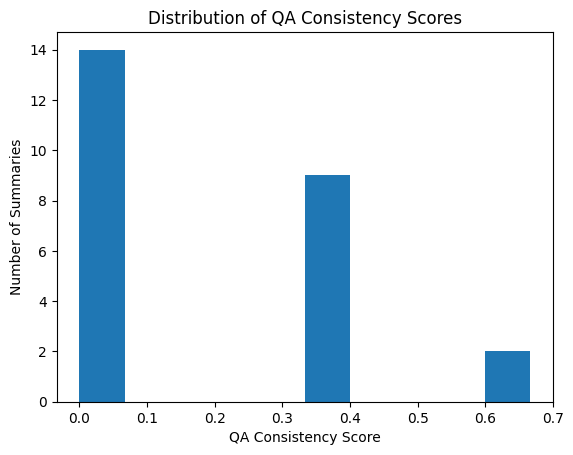

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(consistency_scores, bins=10)
plt.xlabel("QA Consistency Score")
plt.ylabel("Number of Summaries")
plt.title("Distribution of QA Consistency Scores")

plt.show()


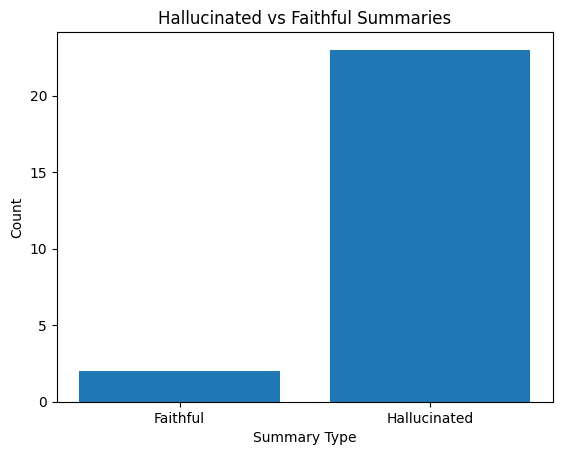

In [42]:
hallucinated = sum(1 for s in consistency_scores if s < 0.5)
faithful = len(consistency_scores) - hallucinated

plt.figure()
plt.bar(["Faithful", "Hallucinated"], [faithful, hallucinated])
plt.xlabel("Summary Type")
plt.ylabel("Count")
plt.title("Hallucinated vs Faithful Summaries")

plt.show()
